In [2]:
!pip install faiss-gpu==1.7.2

     |████████████████████████████████| 85.5 MB 75.1 MB/s eta 0:00:01


In [64]:
import faiss
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
DATA_DIR = Path('data')
embs_path = DATA_DIR / 'cluster_medoids.pickle'
DIR_IMGS = DATA_DIR / 'drone_imgs'
assert embs_path.exists()

In [28]:
embs_df = pd.read_pickle(embs_path)
embs_df.head(1)

,filename,emb,cluster_id
0,f27e2790-8a3b-4ae8-bd79-2cdba2a9942e.png,"[[0.6997, -1.053, 0.5635, -0.1405, -0.6045, -0...",-1


In [48]:
filenames = embs_df.filename.values
embs = np.array([i[0] for i in embs_df.emb.values]).astype(np.float32)

In [57]:
class FaissIndexer:
    def __init__(
        self,
        img_dir: Path,
        img_filenames,
        embs: torch.Tensor
    ):
        """
        img_dir: Path
        img_filenames: List[Path]
        embs: N, D; N - len, D - emb dimenstion
        """
        self.reference_dir = Path(img_dir)
        assert self.reference_dir.exists(
        ), f"Directory with reference images does not exists! {self.reference_dir}"

        self.filenames, self.embs = img_filenames, embs

        self.filenames = np.array([filename for filename in self.filenames]) # TODO: This is possibly shit fix.

        self.metric = faiss.METRIC_INNER_PRODUCT  # TODO: make it as parameter

        faiss.normalize_L2(self.embs)

        xb = self.embs
        self.index = faiss.IndexFlat(xb.shape[1], self.metric)
        self.index.add(xb)
        print('Index intitialized successfully!')

    def search(
        self,
        embs,
        top_k = 10
    ):
        """
        embs: list of torch embs, with dimension D
        top_k: how many to take
        """
        embeddings = embs

        D, I = self.index.search(embeddings, k=len(self.embs))

        for i, emb in enumerate(embs):
            match_idxs = I[i, :]
            ids = self.filenames[match_idxs]
            unique, id_idxs = np.unique(ids, return_index=True)
            k_id_idxs = sorted(id_idxs)[:top_k]
            top_ids = ids[k_id_idxs]
            top_scores = D[i, k_id_idxs]

            matched_imgs = []
            for _id, _score in zip(top_ids, top_scores):
                match_img = {
                    "id":_id,
                    "full_path": str(self.reference_dir/_id),
                    "score": _score
                }
                matched_imgs.append(match_img)

            return matched_imgs

In [58]:
indexer = FaissIndexer(DIR_IMGS, filenames, embs)

Index intitialized successfully!


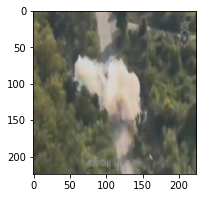

In [77]:
emb2find = embs[3:4]
filename = filenames[3]

plt.figure(figsize=(3, 3))
plt.imshow(Image.open(DIR_IMGS/filename))
plt.show()

In [78]:
search_results = indexer.search(emb2find)

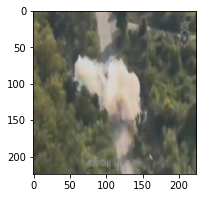

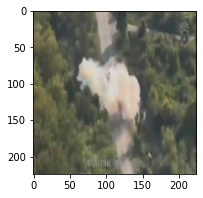

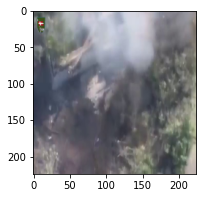

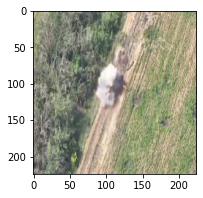

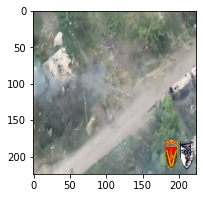

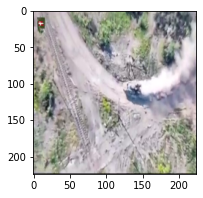

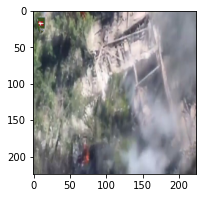

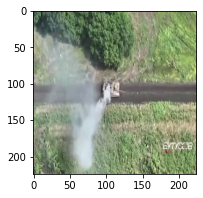

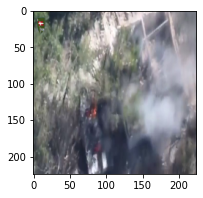

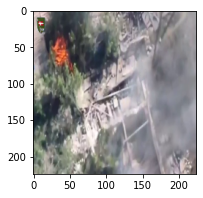

In [79]:
for i in search_results:
    plt.figure(figsize=(3, 3))
    plt.imshow(Image.open(i['full_path']))
    plt.show()